In [8]:
!pip install shap

In [9]:
import pandas as pd
import numpy as np
import xgboost as xgb
import shap



In [17]:
# The following steps are based on the XGBoost code, already shared.
# You can find the data at: https://www.kaggle.com/wordsforthewise/lending-club

# due to memory issues, reading only the first 1,000,000 records

data=pd.read_csv("drive/My Drive/accepted.csv", nrows = 1000000)
data.tail(2)

Columns (0,19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types. Specify dtype option on import or set low_memory=False.


,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
999998,75144864,NaN,20000.0,20000.0,20000.0,60 months,19.53,524.67,D,D5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
999999,75275669,NaN,25000.0,25000.0,25000.0,60 months,8.39,511.59,B,B1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:

final_data = data[["id", "emp_length", "loan_status", "pymnt_plan", "dti", "delinq_2yrs"
,"fico_range_low", "fico_range_high", "inq_last_6mths", "mths_since_last_delinq", "revol_bal",
"revol_util", "total_acc", "avg_cur_bal", "chargeoff_within_12_mths", "hardship_flag"]].copy()

del data

final_data = final_data[final_data.pymnt_plan != "y"]
final_data = final_data[final_data.hardship_flag != "Y"]

final_data = final_data[final_data.loan_status != "Charged Off"]
final_data = final_data[final_data.loan_status != "Default"]
final_data = final_data[final_data.loan_status != "Does not meet the credit policy. Status:Charged Off"]
final_data = final_data[final_data.loan_status != "Does not meet the credit policy. Status:Fully Paid"]
final_data = final_data[final_data.loan_status != "Fully Paid"]
final_data = final_data[final_data.loan_status.notnull()]

final_data['30+ Delinquent'] = np.where((final_data.loan_status == "Current") | 
                                        (final_data.loan_status == "In Grace Period"),0, 1)

final_data.drop(['loan_status', 'hardship_flag', 
                'pymnt_plan'], axis=1, inplace=True)

final_data['dti'].replace(999, np.NaN, inplace = True)

final_data['Employment_Length'] = np.nan
final_data['Employment_Length'] = np.where(final_data.emp_length == "< 1 year", 0, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "1 year", 1, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "2 years", 2, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "3 years", 3, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "4 years", 4, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "5 years", 5, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "6 years", 6, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "7 years", 7, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "8 years", 8, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "9 years", 9, final_data.Employment_Length)
final_data['Employment_Length'] = np.where(final_data.emp_length == "10+ years", 10, final_data.Employment_Length)

final_data.drop(['emp_length'], axis=1, inplace=True)

from sklearn.model_selection import train_test_split
train, test = train_test_split(final_data, test_size=0.3)

del final_data

X_train = train.drop(["id", '30+ Delinquent'], axis = 1)
Y_train = train['30+ Delinquent']

X_test = test.drop(["id", '30+ Delinquent'], axis = 1)
Y_test = test['30+ Delinquent']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a D

In [2]:
df_new = pd.read_csv('final_df.csv', index_col = False)
df_new.shape

(458913, 197)

In [59]:
xtest1 = pd.read_csv('xtest1.csv', index_col = False)
xtest2 = pd.read_csv('xtest2.csv', index_col = False)
ytest1 = pd.read_csv('ytest1.csv', index_col = False)
ytest2 = pd.read_csv('ytest2.csv', index_col = False)
ytrain = pd.read_csv('ytrain.csv', index_col = False)
xtrain = pd.read_csv('xtrain.csv', index_col = False)

In [60]:
final_xgb = xgb.XGBClassifier()
final_xgb.load_model("final_xgb.json")

In [19]:

xgb_instance = xgb.XGBClassifier(n_estimators = 20) # nothing inside paranthesis, meaning we are using default parameters, with 100 trees.

model = xgb_instance.fit(X_train, Y_train)

# A good article on SHAP implementation:
https://towardsdatascience.com/introduction-to-shap-with-python-d27edc23c454


# A Good article explaining SHAP:
https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30

In [20]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [61]:
import shap
shap.initjs()

In [62]:
xtrain.shape

(308200, 46)

In [65]:
explainer = shap.Explainer(final_xgb)
shap_values = explainer(xtest2)

In [71]:
xtest2.shape

(88750, 46)

In [69]:
shap_values.values.shape

(88750, 46)

In [18]:
help(shap.summary_plot)

Help on function summary_legacy in module shap.plots._beeswarm:

summary_legacy(shap_values, features=None, feature_names=None, max_display=None, plot_type=None, color=None, axis_color='#333333', title=None, alpha=1, show=True, sort=True, color_bar=True, plot_size='auto', layered_violin_max_num_bins=20, class_names=None, class_inds=None, color_bar_label='Feature value', cmap=<matplotlib.colors.LinearSegmentedColormap object at 0x7f7d465a6430>, auto_size_plot=None, use_log_scale=False)
    Create a SHAP beeswarm plot, colored by feature values when they are provided.
    
    Parameters
    ----------
    shap_values : numpy.array
        For single output explanations this is a matrix of SHAP values (# samples x # features).
        For multi-output explanations this is a list of such matrices of SHAP values.
    
    features : numpy.array or pandas.DataFrame or list
        Matrix of feature values (# samples x # features) or a feature_names list as shorthand
    
    feature_names :

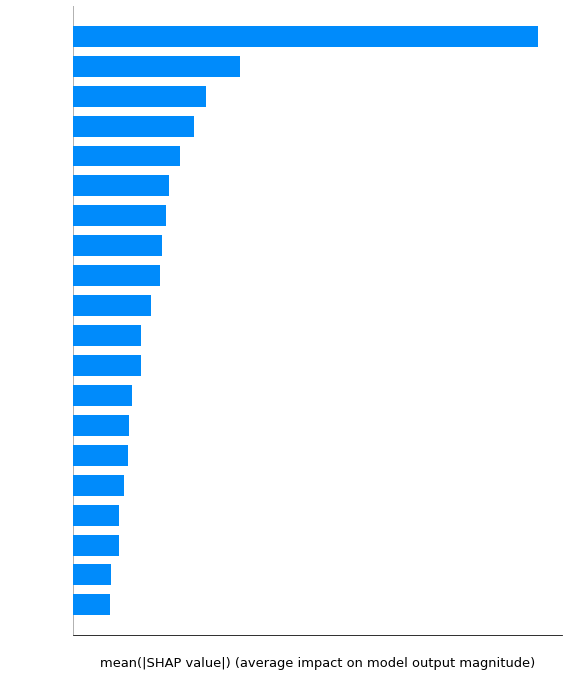

In [19]:
shap.summary_plot(shap_values, xtrain, plot_type='bar', axis_color = 'white')

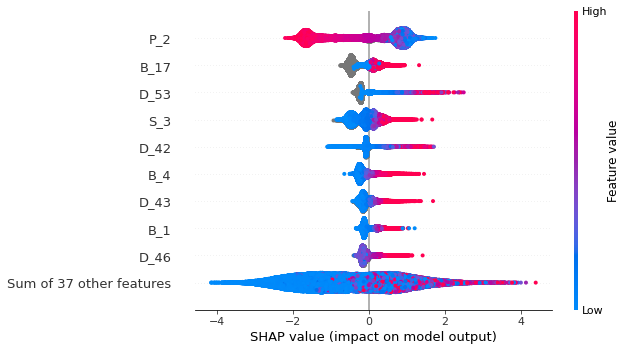

In [66]:
shap.plots.beeswarm(shap_values)

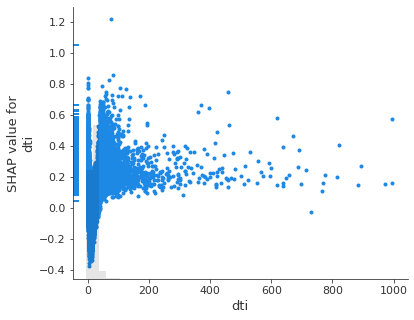

In [ ]:
shap.plots.scatter(shap_values[:,"dti"])

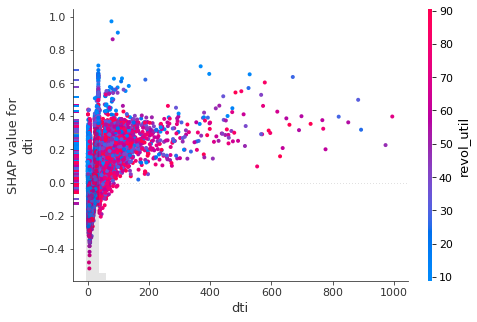

In [ ]:
shap.plots.scatter(shap_values[:,"dti"], color=shap_values[:,"revol_util"])

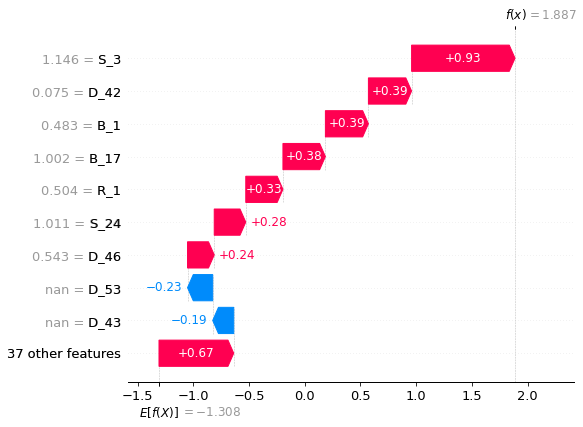

In [72]:
shap.plots.waterfall(shap_values[10])

In [21]:
feat_imp = pd.DataFrame({'columns': xtrain.columns, 'feat_imp': final_xgb.feature_importances_}) # creating table to rank feature importances
feat_imp.sort_values(['feat_imp'], ascending = False)

,columns,feat_imp
28,P_2,0.384626
14,D_42,0.044135
10,B_1,0.038911
15,B_9,0.032076
2,S_3,0.028023
3,B_17,0.026710
11,B_3,0.023754
8,D_53,0.021201
21,D_66,0.020407
12,D_44,0.019332


In [35]:
xtrain.shape

(269243, 44)

In [34]:
xtrain.count()

D_50       124737
R_27       264585
S_3        236579
B_17       147759
B_39         2503
D_48       253023
D_77       216167
D_75       269243
D_53        87144
D_132       36199
B_1        269243
B_3        269243
D_44       259328
B_2        269243
D_42        60938
B_9        269243
D_49        36201
D_111        2490
D_45       269243
D_88         1474
B_5        269243
D_66        35652
B_38       269243
S_23       269243
D_43       214617
D_63_CO    269243
D_41       269243
D_51       269243
P_2        268249
B_7        269243
R_26        31519
D_74       268647
D_62       252487
B_4        269243
D_56       146288
B_10       269243
B_8        269122
D_46       231193
D_76        33375
D_110        2490
P_3        266694
D_64_O     269243
S_7        236579
R_1        269243
dtype: int64

In [45]:
missing = pd.DataFrame(xtrain[['P_2', 'B_17', 'D_53', 'S_3', 'B_4']].isnull().sum())
missing

,0
P_2,994
B_17,121484
D_53,182099
S_3,32664
B_4,0


In [46]:
missing[0]

P_2        994
B_17    121484
D_53    182099
S_3      32664
B_4          0
Name: 0, dtype: int64

In [50]:
182099 + 87144.0

269243.0

In [47]:
missing['%Missing'] = missing[0]/269243

missing.drop(columns = [0], inplace = True)
missing

,%Missing
P_2,0.003692
B_17,0.451206
D_53,0.676337
S_3,0.121318
B_4,0.000000


In [48]:
x_summ = xtrain[['P_2', 'B_17', 'D_53', 'S_3', 'B_4']].describe(percentiles = [.01, .05, .95, .99]).T 

In [51]:
feat = x_summ.join(missing)
feat.to_csv('features.csv')

In [28]:
features = pd.DataFrame(columns = ['Category', '# of Features'])
features['Category'] = ['Delinquency', 'Spend', 'Payment', 'Balance', 'Risk']
features['# of Features'] = 0 

In [29]:
for i in df_new.columns:
    print(i)
    if 'P' in i: 
        print(i)
        features.loc[features['Category'] == 'Payment', '# of Features'] += 1
    if 'S' in i: 
        features.loc[features['Category'] == 'Spend', '# of Features'] += 1
    if 'D' in i: 
        features.loc[features['Category'] == 'Delinquency', '# of Features'] += 1
    if 'B' in i: 
        features.loc[features['Category'] == 'Balance', '# of Features'] += 1
    else: 
        features.loc[features['Category'] == 'Risk', '# of Features'] += 1

features
        

customer_ID
S_2
P_2
P_2
D_39
B_1
B_2
R_1
S_3
D_41
B_3
D_42
D_43
D_44
B_4
D_45
B_5
R_2
D_46
D_47
D_48
D_49
B_6
B_7
B_8
D_50
D_51
B_9
R_3
D_52
P_3
P_3
B_10
D_53
S_5
B_11
S_6
D_54
R_4
S_7
B_12
S_8
D_55
D_56
B_13
R_5
D_58
S_9
B_14
D_59
D_60
D_61
B_15
S_11
D_62
D_65
B_16
B_17
B_18
B_19
D_66
B_20
D_68
S_12
R_6
S_13
B_21
D_69
B_22
D_70
D_71
D_72
S_15
B_23
D_73
P_4
P_4
D_74
D_75
D_76
B_24
R_7
D_77
B_25
B_26
D_78
D_79
R_8
R_9
S_16
D_80
R_10
R_11
B_27
D_81
D_82
S_17
R_12
B_28
R_13
D_83
R_14
R_15
D_84
R_16
B_29
B_30
S_18
D_86
D_87
R_17
R_18
D_88
B_31
S_19
R_19
B_32
S_20
R_20
R_21
B_33
D_89
R_22
R_23
D_91
D_92
D_93
D_94
R_24
R_25
D_96
S_22
S_23
S_24
S_25
S_26
D_102
D_103
D_104
D_105
D_106
D_107
B_36
B_37
R_26
R_27
B_38
D_108
D_109
D_110
D_111
B_39
D_112
B_40
S_27
D_113
D_114
D_115
D_116
D_117
D_118
D_119
D_120
D_121
D_122
D_123
D_124
D_125
D_126
D_127
D_128
D_129
B_41
B_42
D_130
D_131
D_132
D_133
R_28
D_134
D_135
D_136
D_137
D_138
D_139
D_140
D_141
D_142
D_143
D_144
D_145
target
D_63_CO
D_63_CR
D_

,Category,# of Features
0,Delinquency,103
1,Spend,22
2,Payment,3
3,Balance,40
4,Risk,157


In [56]:
ytest2.shape

(88750, 1)

In [53]:
print(ytrain.mean(), ytest1.mean(), ytest2.mean())

target    0.25831
dtype: float64 target    0.234317
dtype: float64 target    0.278287
dtype: float64


In [57]:
df_new.shape

(458913, 197)

In [58]:
df_new.loc[:200, :].to_csv('final_trial.csv', index = False)